## imports

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
from shapely.geometry import Point
import xrspatial

from pycda.grid_utils import ids_from_shape
from pycda.grid_utils import id_to_rowcol
from pycda.cost_distance import CostDistance

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/pycda-01m896H6-py3.10/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## load example data

In [3]:
dem = rioxarray.open_rasterio("../data/subbasin.tif", masked=True).squeeze()
stream_raster = rioxarray.open_rasterio("../data/flowpaths.tif", masked=True).squeeze()
stream_raster = stream_raster.rio.reproject_match(dem)
stream_raster.data[np.isnan(dem.data)] = np.nan

start_point = Point(-220624.000, 36032.000)
end_point = Point(-219663.000, 35749.000)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

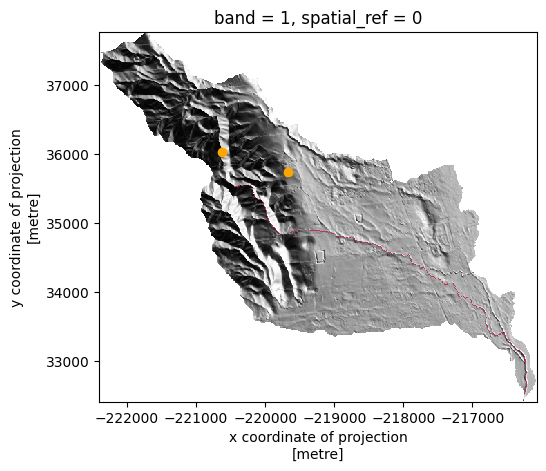

In [4]:
fig, ax = plt.subplots()
hillshade = xrspatial.hillshade(dem)
hillshade.plot(cmap='gray', ax=ax, add_colorbar=False)
stream_raster.plot(ax=ax, cmap='inferno', add_colorbar=False)
gpd.GeoSeries([start_point, end_point], crs=3310).plot(ax=ax, color='orange')

## Create cost raster and initialize cost distance class

In [5]:
slope = xrspatial.slope(dem)
slope = np.deg2rad(slope)
roughness = slope.copy()

# obstacles are set to -1
roughness.data[np.isnan(roughness.data)] = -1
cost_distance = CostDistance(roughness)

## Least Cost Path

In [6]:
path = cost_distance.trace_path(start_point, end_point, return_type='vector')

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

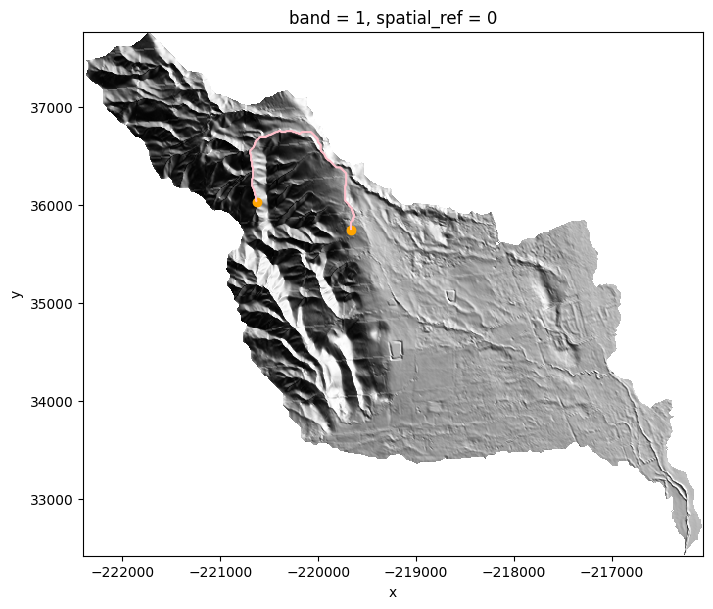

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
hillshade.plot(ax=ax, cmap='gray', add_colorbar=False)
gpd.GeoSeries([start_point, end_point], crs=3310).plot(ax=ax, color='orange')
gpd.GeoSeries(path, crs=3310).plot(ax=ax, color='pink')

## Cost Accumulation

In [9]:
costs, basins = cost_distance.cost_accumulation(sources = (stream_raster > 0), return_basins=True)

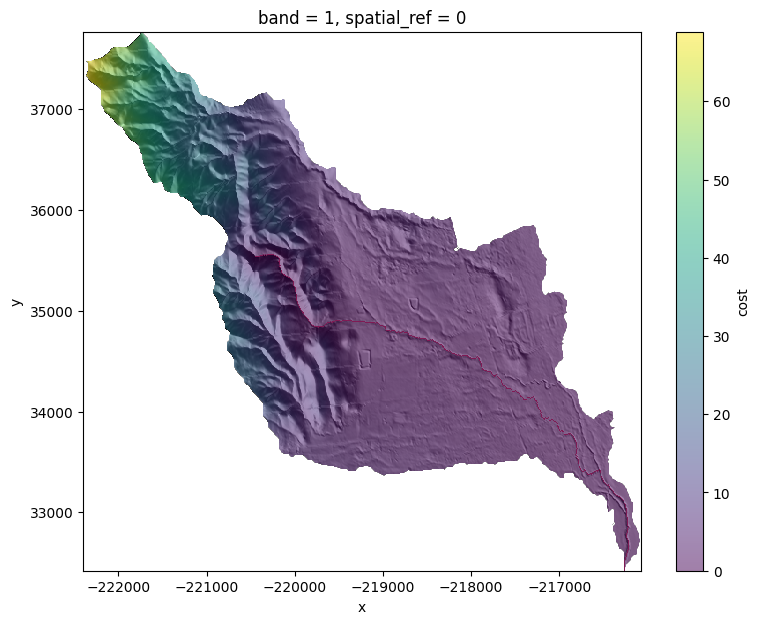

In [15]:
fig, ax = plt.subplots(figsize=(9,7))
hillshade.plot(ax=ax, cmap='gray', add_colorbar=False)
stream_raster.plot(ax=ax, cmap='inferno', add_colorbar=False)
costs.clip(min=0).plot(ax=ax, alpha=0.5)